# Extra- and Intracellular Recordings of Crayfish Ganglia

## Step 1: Format Recording
In this first section, we reformat the raw recording into a fiff file, thereby making it compatible with the *mne-python* package. This will come in handy for preprocessing and analysis.

In [1]:
import neo
import numpy as np
from mne import create_info
from mne.io import RawArray

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
f = 'raw/17925006.abf'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main body.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load recordings.
recordings, = neo.AxonIO(filename=f).read_block().segments
nerve, muscle = recordings.analogsignals

## Concatenate raw recordings.
data = np.hstack([np.asarray(nerve, dtype=np.float64)  * 1e-6, # uV --> V 
                  np.asarray(muscle, dtype=np.float64) * 1e-3  # mV --> V
                 ]).T

## Create info object.
sfreq = float(nerve.sampling_rate)
ch_names = ['nerve', 'muscle']
ch_types = 'bio'

info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

## Create Raw object.
raw = RawArray(data, info)

## Save Raw object.
raw.save('raw/paired_recording_raw.fif', overwrite=True, verbose=False)
print('Done.')

Creating RawArray with float64 data, n_channels=2, n_times=3983360
    Range : 0 ... 3983359 =      0.000 ...    79.667 secs
Ready.
Done.


## Step 2: Preprocess Recording
Next, we open the raw FIFF file and preform preprocessing. For this dataset, preprocessing will entail only filtering the data to remove slow-frequency drifts and high-frequency noise. [Gonzalo Rey et al. (2015)](http://www.sciencedirect.com/science/article/pii/S0361923015000684) recommend a high- and low-pass of 300 and 3000 Hz, respectively, for the extracellular nerve recording.

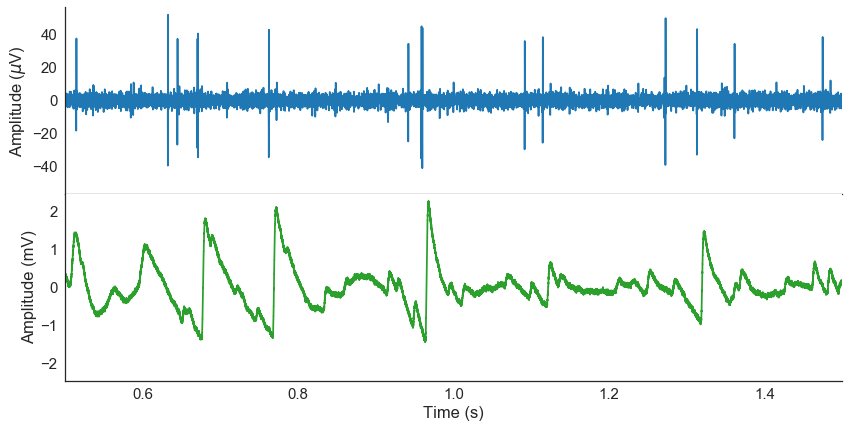

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mne import pick_channels
from mne.io import Raw
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
f = 'raw/paired_recording_raw.fif'

## Filter parameters (nerve).
filter_dict = dict( nerve = (300, 3000),
                    muscle = (10, None))

## Plotting parameters.
tmin = 0.5
tmax = 1.5

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load raw.
raw = Raw(f, preload=True, verbose=False)

## Filter data.
for ch_name in raw.ch_names:
    picks = pick_channels(raw.ch_names, include=[ch_name])
    raw = raw.filter(*filter_dict[ch_name], picks=picks, method='fir', phase='zero')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(2,1,figsize=(12,6),sharex=True)

## Extract data.
data, times = raw.get_data(start=raw.time_as_index(tmin)[0], stop=raw.time_as_index(tmax)[0], return_times=True)

## Iteratively plot.
yscales = [1e6, 1e3]
ylabels = [r'Amplitude ($\mu$V)', r'Amplitude (mV)']
colors = ['#1f77b4', '#2ca02c']

for ax, arr, color, yscale, ylabel in zip(axes, data, colors, yscales, ylabels):

    ## Plot.
    ax.plot(times, arr * yscale, color=color)
    y = np.abs(ax.get_ylim()).max()
    ax.set(xlim=(tmin, tmax), ylim=(-y, y), ylabel=ylabel)
    
ax.set(xlabel='Time (s)')
sns.despine()
plt.subplots_adjust(left=0.05, right=0.95, top=0.99, hspace=0)

## Step 3: Peak Finding
From the plot above, it should be fairly obvious that the action potentials of the nerve align with the excitatory post-synaptic potentials (EPSPs) of the muscle fibers. To confirm this, we need to perform peak-detection. We stick with a simple homebrew implementation of amplitude-thresholding (described in detail in the *spike sorting* notebook). As before, we use a conservative threshold of $T=5$. We additionally perform peak censoring [(Hill et al., 2011)](http://www.jneurosci.org/content/31/24/8699.short).

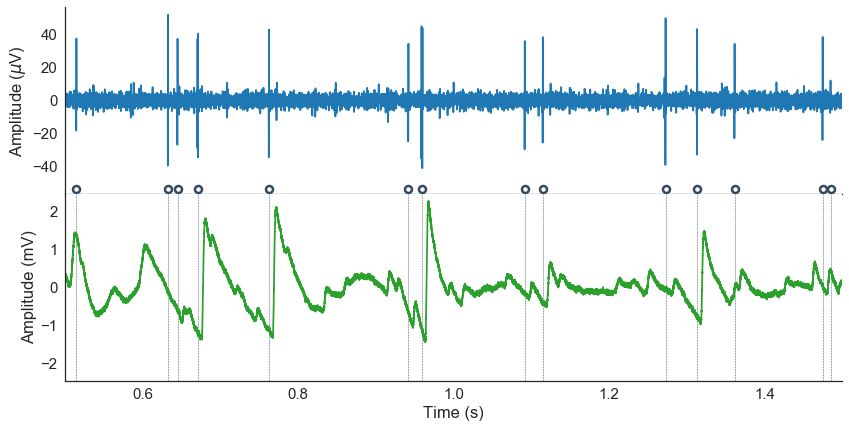

In [3]:
from peak_detection import *

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Perform peak detection.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Extract nerve data.
arr = raw.get_data(picks=pick_channels(raw.ch_names, ['nerve'])).squeeze()

## Threshold.
k = 5
threshold = find_threshold(arr, k)

## Find peaks,
peak_loc, peak_mag = peak_finder(arr, threshold)

## Censor peaks.
peak_loc, peak_mag = peak_censor(raw.times, peak_loc, peak_mag, min_dist=2e-3)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Save results.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Extract data.
data, times = raw.get_data(start=raw.time_as_index(tmin)[0], stop=raw.time_as_index(tmax)[0], return_times=True)

## Save.
np.savez_compressed('paired_recording', data=data, times=times, peak_times=raw.times[peak_loc], peak_mag=peak_mag)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(2,1,figsize=(12,6),sharex=True)

## Iteratively plot.
yscales = [1e6, 1e3]
ylabels = [r'Amplitude ($\mu$V)', r'Amplitude (mV)']
colors = ['#1f77b4', '#2ca02c']

for n, ax, arr, color, yscale, ylabel in zip(range(2), axes, data, colors, yscales, ylabels):

    ## Plot.
    ax.plot(times, arr * yscale, color=color)
    y = np.abs(ax.get_ylim()).max()
    ax.set(xlim=(tmin, tmax), ylim=(-y, y), ylabel=ylabel)
    
    ## Add peak information.
    if not n: ax.scatter(raw.times[peak_loc], np.ones_like(peak_loc)*-y*0.95, marker='o', 
                         color='w', edgecolor="#34495e", linewidth=2.5)
    else: ax.vlines(raw.times[peak_loc], -y, y, linestyle='--', lw=0.5, color="#34495e")
    
ax.set(xlabel='Time (s)')
sns.despine()
plt.subplots_adjust(left=0.05, right=0.95, top=0.99, hspace=0)

## References
1. Hill, D. N., Mehta, S. B., & Kleinfeld, D. (2011). Quality metrics to accompany spike sorting of extracellular signals. Journal of Neuroscience, 31(24), 8699-8705.
2. Quiroga, R. Q., Nadasdy, Z., & Ben-Shaul, Y. (2004). Unsupervised spike detection and sorting with wavelets and superparamagnetic clustering. Neural computation, 16(8), 1661-1687.
3. Rey, H. G., Pedreira, C., & Quiroga, R. Q. (2015). Past, present and future of spike sorting techniques. Brain research bulletin, 119, 106-117. Chicago.
